## Вариант 3
- Параметры задачи: радиусы R1, R2.
- Второй критерий: прочность 1.
- Метод многокритериальной оптимизации: 3
- Граничные условия:
- Зона А - полное закрепление.
- Зона 𝐵 - распределенное усилие, направленное по касательной в каждой точке зоны, чтобы
соответствовать "вращению" восьмиугольника по часовой стрелке.
- Минимальный размер элемента - 10 см.
- Описание детали:
- Деталь - квадрат с 4-мя одинаковыми отверстиями в форме равнобедренных прямоугольных
треугольников и одним восьмиугольным отверстием по центру. Вершины прямых углов всех отверстий 𝐴 находятся на окружности радиуса R2. Гипотенузы треугольных отверстий равны стороне восьмиугольника.

![Image of part](./Detail2.png)

In [150]:
from IPython.display import Image
from IPython.core.display import HTML 
import numpy as np
import scipy.optimize
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline

In [151]:
def rotate(alpha, points=None, point=None):
    c, s = np.cos(np.radians(alpha)), np.sin(np.radians(alpha))
    mat = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
    if point is not None:
        return np.array(mat.dot(point)).reshape(-1, 2)
    elif points is not None:
        return np.array([
            mat.dot(points[i]) for i in range(len(points))
        ]).reshape(-1, 2)

In [152]:
def detail_main_parts(R1, R2, L):
    border = np.array([
        rotate(
            i * 90,
            point=np.array([L/2, L/2])
        )
        for i in range(5)
    ]).reshape(-1, 2)
    
    # Найдём сторону 8угольника
    # https://ru.wikipedia.org/wiki/Правильный_восьмиугольник
    k = 1 + np.sqrt(2)
    t = 2 * R1 / k
    R1_O = t * np.sqrt(k/(k-1)) 
    
    # Построим треугольник:
    #  катет треугольника
    kat = t / np.sqrt(2)
    triangle = np.array([
        [0, 0],
        [0, -kat],
        [-kat, 0],
        [0, 0]
    ]) + [R2 / np.sqrt(2), R2 / np.sqrt(2)]
    
    
    # Построим восьмиугольник
    p = rotate(-45 / 2, point=[0, R1_O])[0]
    octagon = np.array([
        rotate(
            i * 45,
            point=p
        )
        for i in range(9)
    ]).reshape(-1, 2)
    
    return border, triangle, octagon

In [153]:
def split_border(Nodes,N,closed=False):
    points_x = np.array([])
    points_y = np.array([])
    for i in range(Nodes.shape[0]-2):
        points_x = np.append(points_x, np.linspace(Nodes[i,0], Nodes[i+1,0], int(N[i]))[:-1])
        points_y = np.append(points_y, np.linspace(Nodes[i,1], Nodes[i+1,1], int(N[i]))[:-1])
        
    if not closed:   
        points_x = np.append(points_x, np.linspace(Nodes[-2,0], Nodes[-1,0], int(N[-1])))
        points_y = np.append(points_y, np.linspace(Nodes[-2,1], Nodes[-1,1], N[-1]))
    if closed:
        points_x = np.append(points_x, np.linspace(Nodes[-2,0], Nodes[-1,0], int(N[-1]))[:-1])
        points_y = np.append(points_y, np.linspace(Nodes[-2,1], Nodes[-1,1], int(N[-1]))[:-1])
    
    
    return np.hstack((points_x.reshape(-1,1),points_y.reshape(-1,1)))

In [154]:
def show_parts(*parts, **kwargs):
    plt.figure(figsize=(14,8))
    plt.grid(True)
    plt.axis('equal')
    for part in parts:
        plt.plot(part[:,0],part[:,1], 'o-', c='r')

In [155]:
def show_detail(border, triangles, octagon, inner=None):
   
    #show_parts(
    #    split_border(border,       rect_segs, closed=True),
    #    split_border(triangles[0], tri_segs, closed=True),
    #    split_border(triangles[1], tri_segs, closed=True),
    #    split_border(triangles[2], tri_segs, closed=True),
    #    split_border(triangles[3], tri_segs, closed=True),
    #    split_border(octagon,      oct_segs, closed=True)
    #)
    
    show_parts(
        border, 
        triangles[0], triangles[1], triangles[2], triangles[3],
        octagon
    )
    
    if inner is not None:
        plt.plot(inner[:,0],inner[:,1],'.')

In [156]:
def detail_border(R1, R2, L=150, segs_factor=2):
    border, triangle, octagon = detail_main_parts(R1, R2, L)
    
    triangles = np.array([
        triangle, 
        rotate(90, points=triangle), 
        rotate(180, points=triangle), 
        rotate(270, points=triangle)
    ])
    
    return border, triangles, octagon

In [157]:
def octagon_mask(inner, octagon):
    side_len = np.linalg.norm(octagon[0] - octagon[1])

    return np.array([
        np.sum([np.linalg.norm((p1 - p2)) for p1 in octagon[:-1]]) / 6 for p2 in inner
    ]) >= side_len * 2.2

In [158]:
def triangles_mask(inner, triangles):
    return np.array([np.all(p < triangles[0, 0]) and np.all(p > -triangles[0, 0]) for p in inner])

In [159]:
def detail_inner(octagon, triangles, density=25, offset=5, L=150):
    X, Y = np.meshgrid(
        np.linspace(-L / 2 + offset,  L / 2 - offset, density), 
        np.linspace( L / 2 - offset, -L / 2 + offset, density)
    )  
    
    inner = np.vstack((X.ravel(), Y.ravel())).T
    
    mask1 = octagon_mask(inner, octagon)
    mask2 = triangles_mask(inner, triangles)
    ratio = (np.linalg.norm(triangles[0, 1] - triangles[2, 2]) / (1.48 * np.sqrt(3))) / np.linalg.norm(octagon[0] - octagon[1])
    mask3 = octagon_mask(inner, octagon * ratio)
    
    mask =  mask1 & (~mask2 | ~mask3)
    
    inner = inner[mask]
    
    return inner

In [160]:
def detail(R1, R2, segs_factor=1):
    border, triangles, octagon = detail_border(R1, R2, segs_factor=20)
    inner = detail_inner(octagon, triangles, density=60, offset=2)
    
    rect_segs = np.array([17] * 4) * segs_factor
    tri_segs = np.array([4, 5, 4]) * segs_factor
    oct_segs = np.array([5] * 8)   * segs_factor
    
    border1 = split_border(border, rect_segs, closed=True)
    triangles1 = np.array([
        split_border(triangles[0], tri_segs, closed=True),
        split_border(triangles[1], tri_segs, closed=True),
        split_border(triangles[2], tri_segs, closed=True),
        split_border(triangles[3], tri_segs, closed=True)
    ])
    octagon1 = split_border(octagon, oct_segs, closed=True)
    
    Nodes = np.vstack((border1, triangles1[0], triangles1[1], triangles1[2], triangles1[3], octagon1,inner))
    
    #show_detail(border, triangles, octagon, inner)
    
    return Nodes, border, triangles, octagon, inner

In [198]:
def what(R1, R2):
    Nodes, border, triangles, octagon, inner = detail(R1, R2, segs_factor=2)
    
    trng = scipy.spatial.Delaunay(Nodes)
    
    trng_vertices = Nodes[trng.simplices]
    trng_x_verices = trng_vertices[:,:,0]
    trng_y_verices = trng_vertices[:,:,1]
    trng_x_mean = np.mean(trng_x_verices,axis=1)
    trng_y_mean = np.mean(trng_y_verices,axis=1)

    trng_centers = np.hstack((trng_x_mean.reshape(-1,1),trng_y_mean.reshape(-1,1)))

    #masks
    mask1 = octagon_mask(trng_centers, octagon*0.97) 
    mask2 = triangles_mask(trng_centers, triangles)
    ratio = (np.linalg.norm(triangles[0, 1] - triangles[2, 2]) / (1.48 * np.sqrt(3))) / np.linalg.norm(octagon[0] - octagon[1])
    mask3 = octagon_mask(trng_centers, octagon * ratio*1.03)
    mask =  mask1 & (~mask2 | ~mask3)

    simplices = trng.simplices.copy()
    simplices = simplices[mask]
    
    #plt.figure(figsize=(14,8))
    #plt.triplot(Nodes[:,0],Nodes[:,1],simplices)
    #plt.axis('equal')
    
    plt.figure(figsize=(15,15))
    plt.plot(Nodes[:296,0],Nodes[:296,1],'.',c='r')
    for i, p in enumerate(Nodes[:296]):
        plt.text(p[0], p[1], ' %d'%i)
    plt.axis('equal')
    plt.grid(True)

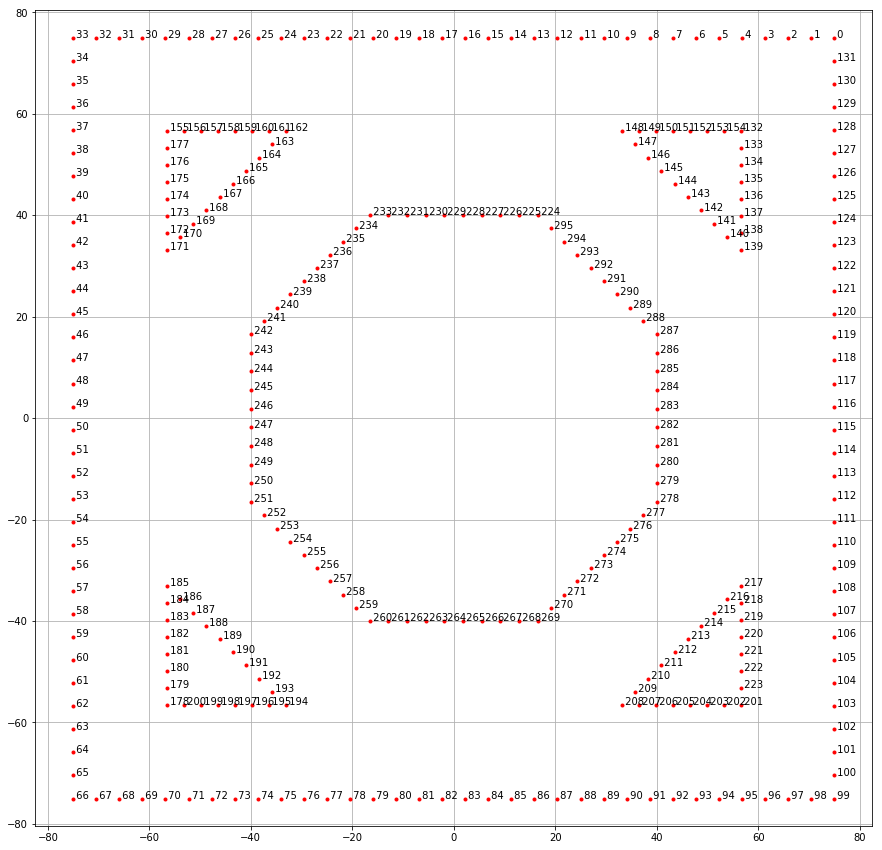

In [199]:
what(40, 80)